### Quick Guide to Using Jupyter Notebooks

- A notebook is made up of **cells**, which can contain either code (Python) or text (Markdown).  
- To run a cell, select it and press **Shift + Enter** (or the ▶️ button in the toolbar).  
- Variables you define in one cell remain **alive in memory** until you restart the kernel.  
- Cells can be executed in any order, but running them **sequentially from top to bottom** is usually the safest way.  
- If results look inconsistent, you can **restart the kernel** (from the Kernel menu) and re-run the cells.  

---

ℹ️ For a more detailed introduction to Jupyter notebooks, see the [Jupyter documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html) or the [official tutorial](https://jupyter.org/try).


### Machine learning and beam management

Millimeter-wave (mmWave) communication systems rely on narrow beams to achieve sufficient receive signal power. Adjusting these beams is typically associated with a **large measuremnt overhead** as the standard procedure is to try all pre-defined directions and selecting the one with highest received signal power.

Beam selection can benefit from the knowledge of **user positions, coupled with machine learning techniques**, to reduce the overhead in mm Wave beam training.

In this example we will use real-world data from the DeepSense6G dataset (https://www.deepsense6g.net) that contains
positions measurements obtained by commercial-off-the-shelf GPS. For each **GPS position we will have an associated vector of received powers for each of the 64 pre-defined directions.**

We will start by exploring and processing the data and continue with the design and implementation of a basic neural network to predict the best direction given a gps position. 

This lab is partly based on [1] and [2]

[1] Morais, J., Bchboodi, A., Pezeshki, H. and Alkhateeb, A., 2023, May. Position-aided beam prediction in the real world: How useful GPS locations actually are?. In ICC 2023-IEEE International Conference on Communications (pp. 1824-1829). IEEE.

[2] D. Cometti, S. Mazuelas, G. Sacco, N. Blefari-Melazzi, and S. Bartoletti, “Location-Aided Iterative Beam Search via Learning-based Generative Models,” in Proc. IEEE Int. Conf. Commun. (ICC) Workshops, accepted for publication, June 2025.


## Clone the repository by running the cell below

In [ ]:
# --- Setup: clone lab repo and enter it ---
!git clone https://github.com/dontolon/ml_beam_management_lab.git
%cd ml_beam_management_lab


In [1]:
%cd /Users/dante/Desktop/school/code/lab/ml_beam_management_lab


/Users/dante/Desktop/school/code/lab/ml_beam_management_lab


### Install dependencies

In [ ]:
!pip install numpy>=1.22 pandas>=1.5 matplotlib>=3.6 torch>=2.0 scikit-learn>=1.2 utm>=0.7

### Import dependencies

In [2]:
import numpy as np
from pathlib import Path
from helper_scripts.load_data import normalize_pos, min_max, build_mlp, run_epoch, evaluate, make_client_loaders, plot_client_split,split_noniid_label_dirichlet,split_iid_equal_indices, _normalize_for_plot, get_state_dict,set_state_dict,local_train_on_client,fedavg,sample_clients_indices,federated_round
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn


#### Load the data

We will import and load scenario 2 from the DeepSense6G dataset (https://www.deepsense6g.net/scenario-2/) 

This scenario emulates a Vehicle-to-Infrastructure (V2I) mmWave communication setup. 

We consider a system where a base station (BS) with $N$ antennas communicates with a single-antenna UE using one of the $M$ beamforming vectors $\mathbf{f}_m \in \mathbb{C}^{N \times 1}$ present in its codebook 
$\mathcal{F} = \{\mathbf{f}_m\}_{m=1}^M$.

In our case:  
- $M = 64$ beamforming vectors,  
- $N = 16$ antennas at the BS,  
- carrier frequency is **60 GHz**.  

#### Video

You can watch a quick video on the data gathering process here https://www.youtube.com/watch?v=67mehcyByLU&t=5s


![](../images/g66-1.png)



In [3]:
# DO NOT CHANGE

DATA_DIR = Path("data")

# Base station coordinates
BS_location = np.array([[33.42034722222222, -111.92915277777779]])

# UE Positions (lat, lon)
UE_locations = np.load(DATA_DIR / "scenario2_unit2_loc_1-2974.npy")[:, :2]

# Beam powers (linear scale)
beam_powers = np.load(DATA_DIR / "scenario2_unit1_pwr_60ghz_1-2974.npy")

print("BS_location:", BS_location.shape)
print("UE_locations:", UE_locations.shape)
print("beam_powers:", beam_powers.shape)

BS_location: (1, 2)
UE_locations: (2974, 2)
beam_powers: (2974, 64)


#### Preparing the data: BS and UE positions

In this step, we prepare the spatial data before visualization and modeling:

- We **stack** the base station (BS) and user equipment (UE) positions together into one array.  
- We then apply **min–max normalization** across all coordinates so that the BS and UE positions are represented in a comparable, normalized coordinate system between 0 and 1.  

This ensures that:
- Both BS and UE positions are expressed on the same scale.  
- Visualization and downstream models (e.g., beam selection models) are not biased by raw latitude/longitude magnitudes.  

After normalization:
- The **first row** corresponds to the BS.  
- The **remaining rows** correspond to the UEs.


In [4]:
# Stack BS and UEs together
all_positions = np.vstack([BS_location, UE_locations])  # (1+N, 2)

# Min-max normalize everything
all_norm = min_max(all_positions, axis=0)

# First row is BS, rest are UEs
BS_norm = all_norm[0:1]
UE_norm = all_norm[1:]

#### Visualizing the normalized positions

Here, we create a scatter plot to visualize the **normalized positions** of the BS and UEs:

- The BS is shown as a red star.  
- The UEs are shown as small blue dots.  

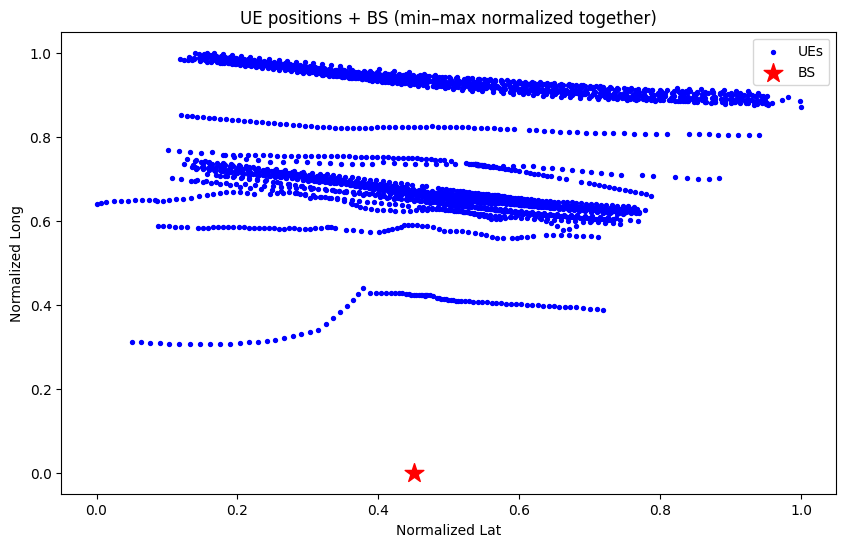

In [5]:
# Plot normalized positions

plt.figure(figsize=(10,6))
plt.scatter(UE_norm[:,0], UE_norm[:,1], c="blue", s=8, label="UEs")
plt.scatter(BS_norm[0,0], BS_norm[0,1], c="red", marker="*", s=200, label="BS")
plt.xlabel("Normalized Lat")
plt.ylabel("Normalized Long")
plt.title("UE positions + BS (min–max normalized together)")
plt.legend()
plt.show()


#### Exploring beam power profiles 

Let's randomly pick one sample from the dataset and explore:

1. **Beam power profile (left plot):**  
   - Shows the received power values across all 64 beams for the chosen UE.  
   - Index with the highest received power value.
   
2. **Spatial view (right plot):**  
   - Shows all normalized UE positions (blue dots).  
   - The BS is marked with a red star.  
   - The randomly selected UE is highlighted in orange. 

Run the plot multiple times to get the intuition behind why GPS positions can allow us to predict the best beam index. 


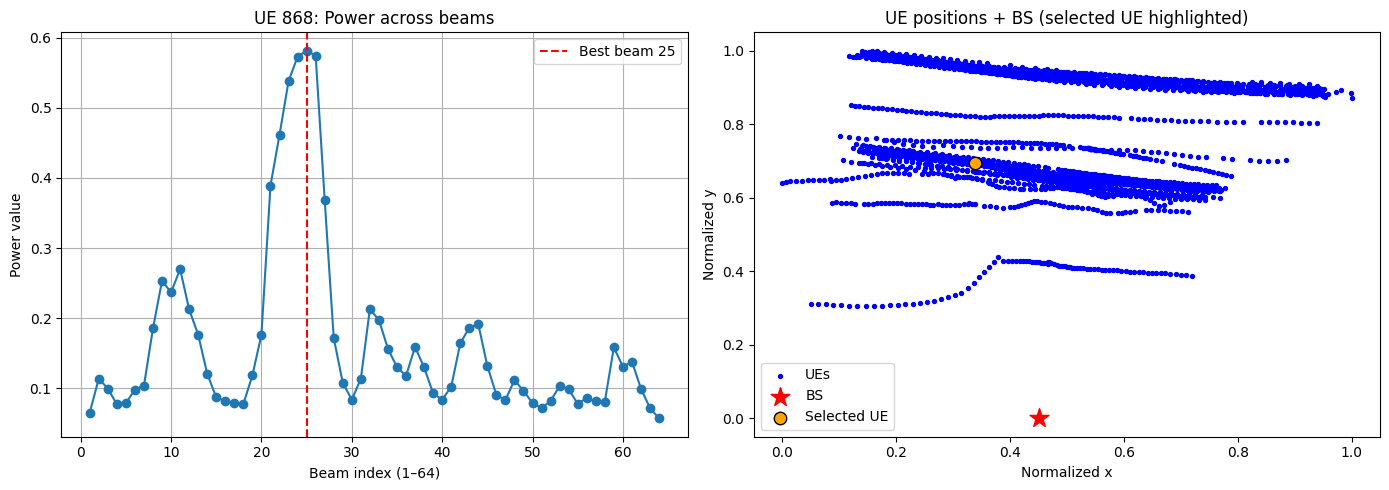

In [6]:
# Visualize beam power profile for a random UE

idx = np.random.randint(0, beam_powers.shape[0])
powers = beam_powers[idx]

fig, axes = plt.subplots(1, 2, figsize=(14,5))
best_idx = np.argmax(powers)

# --- Left: beam power profile ---
axes[0].plot(range(1, len(powers)+1), powers, marker="o")
axes[0].axvline(best_idx+1, color="red", linestyle="--", label=f"Best beam {best_idx+1}")
axes[0].set_xlabel("Beam index (1–64)")
axes[0].set_ylabel("Power value")
axes[0].set_title(f"UE {idx}: Power across beams")
axes[0].legend()
axes[0].grid(True)

# --- Right: spatial scatter ---
axes[1].scatter(UE_norm[:,0], UE_norm[:,1], c="blue", s=8, label="UEs")
axes[1].scatter(BS_norm[0,0], BS_norm[0,1], c="red", marker="*", s=200, label="BS")
axes[1].scatter(UE_norm[idx,0], UE_norm[idx,1], c="orange", edgecolor="black", s=80, label="Selected UE")
axes[1].set_xlabel("Normalized x")
axes[1].set_ylabel("Normalized y")
axes[1].set_title("UE positions + BS (selected UE highlighted)")
axes[1].legend()

plt.tight_layout()
plt.show()


#### Constructing the beam prediction dataset

So far, we’ve visualized single UEs and their beam power profiles.  
Now we take the next step: create the dataset for supervised learning.

- For each sample, we find its **best beam index**:  
$$
m^* = \arg\max_{m \in \{1, \dots, M\}} \; \text{beam\_powers}_{m},
$$

- We then define:  
  - **Features (X):** the normalized UE positions (shape = (N, 2))  
  - **Labels (y):** the best beam index for each sample (shape = (N,))  

This dataset \((X, y)\) is the starting point for training models to **predict the best beam** from position information.


In [7]:
# Get best beam index for each UE and create dataset

best_beam = np.argmax(beam_powers, axis=1)
X = UE_norm      # shape (N,2)
y = best_beam    # shape (N,)

print("Dataset created:")
print("X:", X.shape, "y:", y.shape)


Dataset created:
X: (2974, 2) y: (2974,)


#### Visualizing spatial patterns of best beams

Now that we have constructed the dataset \((X, y)\), we can visualize how the **best beam index** varies across space:

- Each sample is plotted at its normalized position \((x, y)\).  
- The color encodes the **best beam index** \(m^*\).  
- The colorbar on the right shows the mapping from color → beam index.  

This plot lets us see the **spatial partitioning of beams**:  
- Neighboring samples often share the same best beam.  

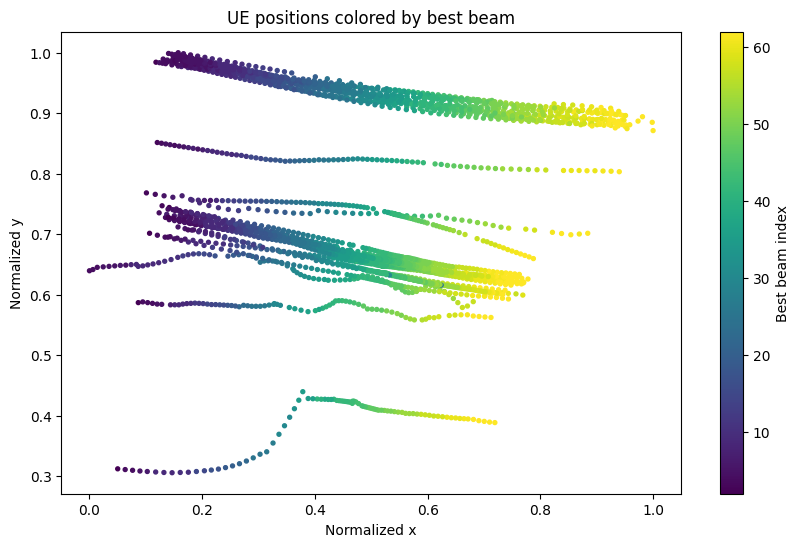

In [8]:
# Plot UE positions colored by best beam

plt.figure(figsize=(10,6))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap="viridis", s=8)
plt.colorbar(sc, label="Best beam index")
plt.xlabel("Normalized x")
plt.ylabel("Normalized y")
plt.title("UE positions colored by best beam")
plt.show()


#### Preparing the dataset for PyTorch

Now that we have the feature matrix $X$ (UE positions) and the labels $y$ (best beam indices), we need to prepare them for training a neural network in PyTorch.

Steps:
1. **Convert to tensors:**  
   - `X_tensor`: the input features (shape: $N \times 2$).  
   - `y_tensor`: the target labels (shape: $N$, with values in $\{0, \dots, M-1\}$).

2. **Bundle into a dataset:**  
   - `TensorDataset` combines the inputs and labels into a format that PyTorch understands.

3. **Wrap with a DataLoader:**  
   - Handles batching (here: 128 samples per batch).  
   - Shuffles the data each epoch for better generalization.  
   - Makes it easy to iterate over the dataset in training loops.


In [9]:
# Convert to PyTorch tensors

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Bundle into a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Create a DataLoader (mini-batches)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Dataset ready for NN training!")
print("Number of batches:", len(loader))


Dataset ready for NN training!
Number of batches: 24


### Splitting the dataset into train/validation/test

To properly train and evaluate our model, we need to split the dataset into three parts:

1. **Training set (70%)**  
   - Used by the neural network to learn the mapping from UE positions → best beam indices.

2. **Validation set (15%)**  
   - Used to tune hyperparameters and prevent overfitting.  
   - The model never directly trains on this data.

3. **Test set (15%)**  
   - Held out until the very end.  
   - Used to evaluate the *true generalization performance*.

In [10]:
# Split into train/val/test with a 70/15/15 ratio

# 70/30 split first
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Then split 30 into 15/15
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# Convert to PyTorch tensors
def make_loader(X, y, batch_size=32, shuffle=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader   = make_loader(X_val,   y_val,   batch_size=32)
test_loader  = make_loader(X_test,  y_test,  batch_size=32)


Train: (2081, 2) (2081,)
Val:   (446, 2) (446,)
Test:  (447, 2) (447,)


### Building the model and training components

The helper function `build_mlp(...)` constructs not only the neural network architecture, but also the essential components for training:

- **Model:** a configurable MLP with user-defined depth, width, and activation.  
- **Loss function (criterion):** categorical cross-entropy, suitable for multi-class classification.  
- **Optimizer:** Adam, with configurable learning rate.  
- **Scheduler:** a multi-step learning rate scheduler that reduces the learning rate by a factor $\gamma$ at predefined milestones.


### Hyperparameter tuning

- Try and change each parameter to see how it affects training 
- What is the highest top-1 accuracy you can achieve? Top-10?
- How many epochs are necessary to reach acceptable results with your neural network architecture?

**RERUN THE 2 CELLS BELOW FOR YOUR CHANGES TO TAKE EFFECT**

In [11]:
# Build model and training components

model, criterion, optimizer, scheduler = build_mlp(
    input_dim=2,
    output_dim=64,
    hidden_dim=256,
    hidden_layers=3,
    activation="ReLU",
    lr=1e-4,
    milestones=[20, 40],
    gamma=0.2,
)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=64, bias=True)
)


In [12]:
# Hyperparameters to tune

# Number of training rounds
EPOCHS = 60
# Top-k values for evaluation
k_values = [1,2,3,4,5,6,7,8,9,10]

#### Training loop and evaluation protocol

We now implement the complete training and evaluation routine for the beam prediction model.

**1. Training step (`run_epoch`)**
- Iterates over one pass of the dataset (an epoch).  
- Sets the model to training or evaluation mode.  
- For each mini-batch:
  - Computes forward pass (`out = model(xb)`).  
  - Evaluates the loss using categorical cross-entropy.  
  - If training:
    - Clears gradients (`optimizer.zero_grad()`).  
    - Backpropagates (`loss.backward()`).  
    - Updates parameters (`optimizer.step()`).  
- Tracks average loss and top-1 accuracy for the epoch.

**2. Evaluation step (`evaluate`)**
- Runs the model in inference mode (no gradient computation).  
- Computes **top-k accuracies** for several values of \(k\) (1, 3, 5, 10):  
  - For each sample, checks whether the ground-truth beam index appears among the model’s top-\(k\) predicted beams.  
- Returns a dictionary mapping \(k \mapsto \text{accuracy}\).

**3. Training loop**
- Repeats for a fixed number of epochs (here, 60).  
- Each epoch:
  - Calls `run_epoch` on the training set.  
  - Evaluates on the validation set using `evaluate`.  
  - Updates the learning rate via the scheduler.  
- Records the training history (loss, accuracy) and validation metrics.  
- Periodically prints progress (every 10 epochs, and during the first 5).

**WHEN TRYING DIFFERENT ARCHITECTURES AND HYPERPARAMETERS RE RUN THE 2 CODING CELLS ABOVE TO APPLY THE CHANGES BEFORE RETRAINING**

In [13]:
# MAIN TRAINING LOOP

train_hist, val_hist = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(train_loader, model, optimizer, criterion, train=True) # <-- get train loss, acc
    va_loss, va_acc = run_epoch(val_loader, model, optimizer, criterion, train=False)   # <-- get val loss, acc
    val_metrics = evaluate(val_loader, model, k_values=k_values)
    scheduler.step()
    train_hist.append((tr_loss, tr_acc))
    val_hist.append((va_loss, va_acc, val_metrics))   # save loss + accs

    if (epoch+1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:02d}: Train loss {tr_loss:.3f}, Val loss {va_loss:.3f}, "
              f"Train acc {tr_acc:.3f}, Val top-1 {val_metrics[1]:.3f}")

Epoch 01: Train loss 4.082, Val loss 3.967, Train acc 0.081, Val top-1 0.103
Epoch 02: Train loss 3.820, Val loss 3.709, Train acc 0.104, Val top-1 0.103
Epoch 03: Train loss 3.709, Val loss 3.639, Train acc 0.104, Val top-1 0.103
Epoch 04: Train loss 3.608, Val loss 3.555, Train acc 0.106, Val top-1 0.114
Epoch 05: Train loss 3.501, Val loss 3.415, Train acc 0.140, Val top-1 0.132
Epoch 10: Train loss 2.814, Val loss 2.786, Train acc 0.207, Val top-1 0.209
Epoch 20: Train loss 2.248, Val loss 2.187, Train acc 0.305, Val top-1 0.323
Epoch 30: Train loss 2.121, Val loss 2.104, Train acc 0.344, Val top-1 0.370
Epoch 40: Train loss 2.039, Val loss 2.056, Train acc 0.365, Val top-1 0.381
Epoch 50: Train loss 2.044, Val loss 2.039, Train acc 0.359, Val top-1 0.386
Epoch 60: Train loss 2.023, Val loss 2.028, Train acc 0.357, Val top-1 0.381


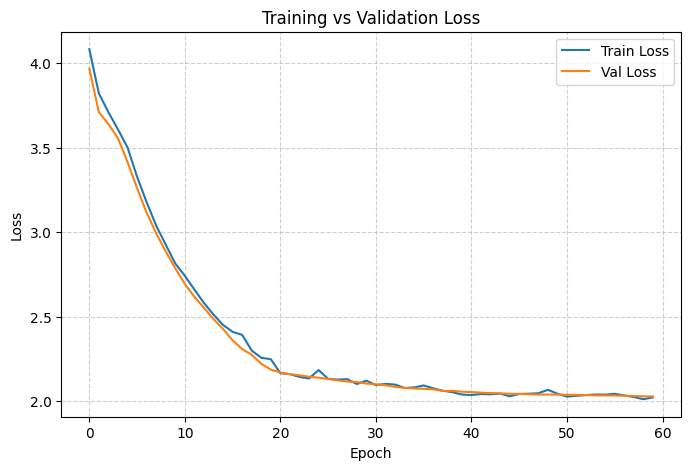

In [14]:
# Plot training and validation loss curves

plt.figure(figsize=(8,5))
plt.plot([tr[0] for tr in train_hist], label="Train Loss")
plt.plot([vh[0] for vh in val_hist], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#grid
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


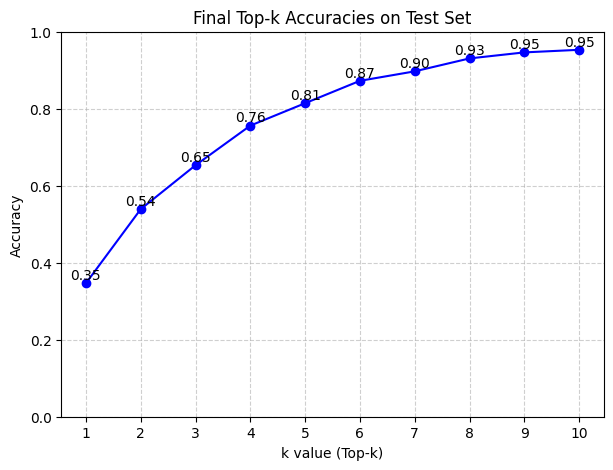

In [15]:
# Evaluate final model on validation or test set
final_metrics = evaluate(test_loader, model, k_values=k_values)

# Prepare data
x_vals = list(final_metrics.keys())
y_vals = [final_metrics[k] for k in x_vals]

# Line plot
plt.figure(figsize=(7,5))
plt.plot(x_vals, y_vals, marker="o", linestyle="-", color="blue")
plt.xticks(x_vals)
plt.ylim(0,1)
#grid
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("k value (Top-k)")
plt.ylabel("Accuracy")
plt.title("Final Top-k Accuracies on Test Set")

# Annotate each point with accuracy value
for x, y in zip(x_vals, y_vals):
    plt.text(x, y+0.01, f"{y:.2f}", ha="center")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Extra: Federated Neural Network

## Introduction to Federated Learning

In centralized training, all data is collected in a single place and the model is trained directly on it.  
In **federated learning (FL)**, the data remains distributed across many clients (e.g., devices, sensors, or users).  

The process works as follows:
1. The server sends a **global model** to the clients.  
2. Each client trains the model locally on its own data.  
3. Clients send back **updates** (not raw data) to the server.  
4. The server **aggregates** these updates (e.g., with FedAvg) to form a new global model.  
5. Steps 1–4 repeat for several **rounds**.  

This setup preserves **data privacy** (since data never leaves the client) and allows training across **heterogeneous datasets**, but also makes optimization more challenging compared to centralized training.


![](../images/Federated-Learning-(1).png)


###  IID vs Non-IID client splits

In federated learning, how data is divided among clients strongly affects training:

- **IID split (uniform & equal):**  
  Each client receives roughly the same number of samples, drawn randomly from the whole dataset.  
  → Clients look very similar, which makes federated learning easier.

- **Non-IID (size skew):**  
  Clients receive **different numbers of samples** (using a Dirichlet distribution over client sizes).  
  Some clients get lots of data, others very little.  
  → Simulates devices with unbalanced participation (e.g., some phones sending many updates, others rarely).

- **Non-IID (label skew):**  
  Clients receive **different proportions of labels/classes** (using Dirichlet over labels).  
  Some clients may mostly see certain beams, while others mostly see different beams.  
  → Simulates devices collecting biased data (e.g., users always in certain areas of the network).

Having both kinds of non-IID splits make the federated learning problem harder and more realistic.  



### IID client split

In this step, we divide the dataset into **IID (Independent and Identically Distributed)** partitions.  
That means each client receives roughly the **same number of samples**, drawn uniformly at random from the dataset.  

The plot below shows:  
- **Samples** → UE positions belonging to different clients (each client has its own color).  
- **Red star** → the base station (BS).  

This split simulates the case where **all clients have balanced data**, which is the "easiest" setting for federated learning.


# YOU MUST RERUN THE CELL BELOW EVERY TIME YOU MAKE CHANGES TO THE CLIENT SPLIT

In [29]:
# Labels from powers
best_beam = np.argmax(beam_powers, axis=1)

# Features (normalized positions)
X = UE_norm
y = best_beam

# --- Keep track of indices too ---
idx_all = np.arange(len(y))

# Train / temp split
train_idx, temp_idx = train_test_split(
    idx_all, test_size=0.3, random_state=42
)

# Val / test split
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42
)

# Now slice arrays
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

N = len(y_train)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (2081, 2) (2081,)
Val:   (446, 2) (446,)
Test:  (447, 2) (447,)


In [30]:
# CHANGE THIS TO DECIDE THE NUMBER OF CLIENTS IN THE IID SPLIT
num_clients_iid = 20

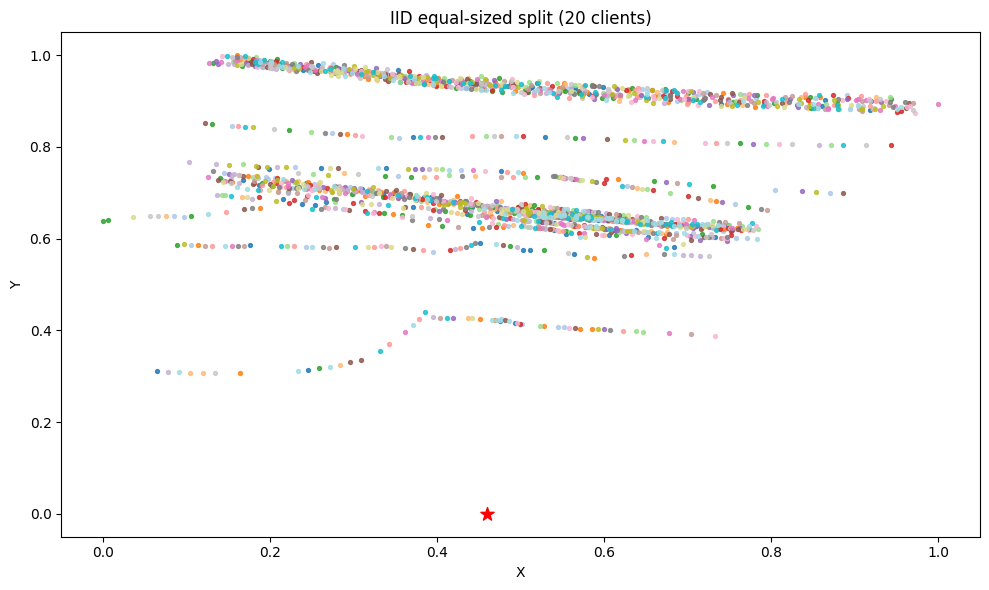

In [31]:
# You have to rerun the first cell in the federated part to avoid any errors.

clients_iid = split_iid_equal_indices(N, num_clients=num_clients_iid, seed=0)

plot_client_split(
    UE_locations[train_idx],   # use training subset only
    clients_iid,
    BS_location=BS_location,
    normalize=True,
    title=f"IID equal-sized split ({num_clients_iid} clients)"
)





### Non-IID split

### Dirichlet-based Non-IID splits

The function `split_noniid_label_dirichlet` can create different federated data splits depending on its parameters:

- **`alpha_sizes`** → controls *how balanced client dataset sizes are*.  
  - Large → all clients get about the same number of samples.  
  - Small → some clients get many samples, others very few.  
  - It can be set to any positive real number

- **`alpha_labels`** → controls *how mixed the labels/classes are inside each client*.  
  - Large → each client sees a mix of all labels (IID-like).  
  - Small → each client specializes in only a few labels (class skew).  
  - It can be set to any positive real number


By tuning these two parameters, you can simulate:
- **IID data** → both alphas large  
- **Size-skew non-IID** → small `alpha_sizes`, large `alpha_labels`  
- **Label-skew non-IID** → large `alpha_sizes`, small `alpha_labels`  
- **Combined skew** → both small  

This lets us study how different data distributions across clients affect the performance of federated learning.


In [19]:
# TUNE BOTH ALPHAS HERE
alpha_labels = 0.5
alpha_sizes = 100
# CHANGE THIS TO DECIDE THE NUMBER OF CLIENTS IN THE NON-IID SPLIT
num_clients_noniid = 3

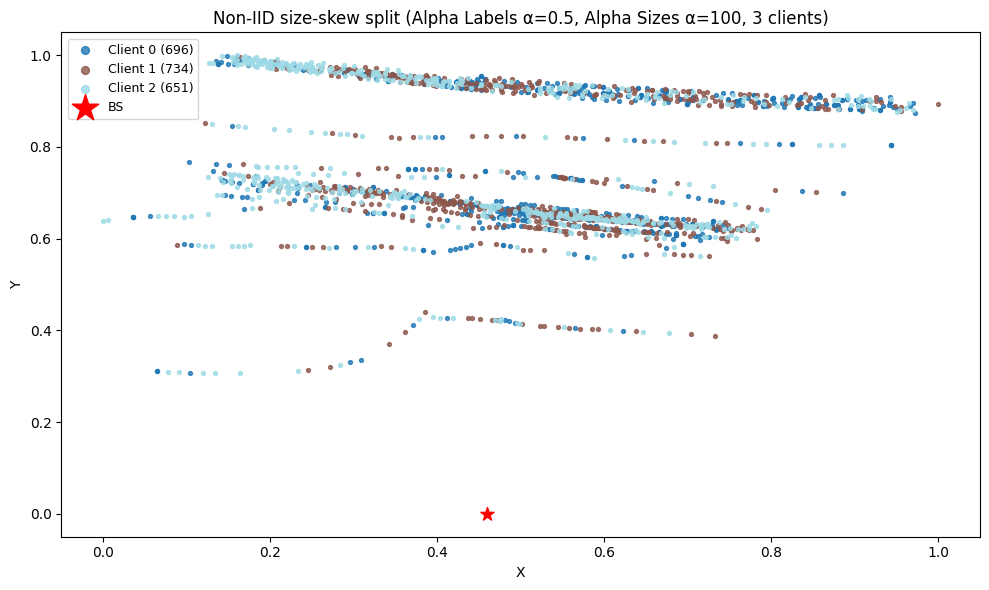

In [32]:
# VISUALIZE THE SIZE SPLIT
clients_noniid = split_noniid_label_dirichlet(
    y_train, num_clients=num_clients_noniid,
    alpha_labels=alpha_labels, alpha_sizes=alpha_sizes,
    min_per_client=50, seed=0
)

plot_client_split(
    UE_locations[train_idx],   # not the full UE_locations
    clients_noniid,
    BS_location=BS_location,
    normalize=True,
    title=f"Non-IID size-skew split (Alpha Labels α={alpha_labels}, Alpha Sizes α={alpha_sizes}, {num_clients_noniid} clients)"
)


### Make clients

In [21]:
# PICK IF YOU WANT TO USE IID OR NON-IID SPLIT
# RE-RUN THE CELLS ABOVE IF YOU WANT TO RE-DEFINE THE SPLIT AND RUN THE FEDERATED LOOP

chosen_split = clients_iid   # clients_iid or clients_noniid

client_loaders = make_client_loaders(X_train, y_train, chosen_split, batch_size=32, shuffle=True)


### Federated framework hyperparameters

### Federated learning hyperparameters

The configuration below defines the main **training hyperparameters** for our federated setup:

- **`rounds`** → number of **federated communication rounds**.  
  In each round, clients train locally and then synchronize with the server.  
  More rounds = longer training, but also higher accuracy (up to a point).  

- **`local_epochs`** → number of **local training epochs per client** before sending updates.  
  If this is large, clients learn more from their own data but risk **diverging** if the data is very different (non-IID).  
  If this is small, clients communicate more often, which increases **communication cost**.  

- **`lr` (learning rate)** → step size of the optimizer on each client.  
  Higher values speed up learning but may cause instability.  
  Lower values are more stable but require more rounds.  

- **`weight_decay`** → regularization term that penalizes large weights (L2 regularization).  
  Helps avoid overfitting, though in many FL setups this can be left at `0.0`.  

By adjusting these hyperparameters, we can study the **trade-offs between accuracy, convergence speed, and communication efficiency** in federated learning.


In [22]:
# Federated learning configuration to tune

fed_cfg = {
    "rounds": 60,
    "local_epochs": 2,
    "lr": 1e-4,
    "weight_decay": 0.0
}


### Model constructor (`model_ctor`)

The function `model_ctor()` builds the a neural network, same method as the centralized training part:
- **Input dimension = 2** (the normalized UE position `[x, y]`)
- **Output dimension = 64** (the beam index classes)
- **Hidden layers = 3**, each of size **256**, with **ReLU activations**

It also sets up the **optimizer** and **scheduler** with the same hyperparameters (learning rate, milestones, decay rate) that we had in the centralized training.  

The key difference is that in **federated learning**, this constructor is called **separately on each client**.  
Each client starts from the **current global model weights**, trains locally, and then the server averages the updates (FedAvg).  

To correctly compare between FEDERATED and CENTRALIZED frameworks use the same neural network architecture for both.


In [23]:
# Here we define a model constructor function to create a new model instance for each client
# This is important to ensure that each client starts with the same initial weights
# and that the model architecture is consistent across clients

def model_ctor():
    # keep these hyperparams aligned with your centralized setup if you want to compare
    return build_mlp(
        input_dim=2,
        output_dim=64,
        hidden_dim=256,
        hidden_layers=3,
        activation="ReLU",
        lr=1e-4,                 # local client LR
        milestones=[20, 40],     # local scheduler (optional)
        gamma=0.2,
    )


In [24]:
# Create the server/global model once DO NOT CHANGE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model, _, _, _ = model_ctor()
global_model = global_model.to(DEVICE)


### Federated training loop

In this cell, we run the **federated training process**:

- The loop runs for the number of **rounds** specified in `fed_cfg`.  
- In each round:
  1. All clients are selected.  
  2. Each selected client trains the model locally for `local_epochs`.  
  3. The server aggregates all client updates into a new **global model** (FedAvg).  
- After each round, we evaluate the global model on the **validation set** and record its **Top-k accuracies**.  

At the end of training, we evaluate the final global model on the **test set** and report the accuracies.  

This mirrors the centralized loop, but instead of training on all data at once, we train **collaboratively across clients** with local updates + aggregation.


In [25]:
fed_val_hist = []
for r in range(1, fed_cfg["rounds"] + 1):
    _ = federated_round(
        model=global_model,
        model_ctor=model_ctor,
        clients=client_loaders,
        client_fraction=1,
        local_epochs=fed_cfg["local_epochs"],
        seed=42 + r,
    )
    val_metrics = evaluate(val_loader, global_model, k_values=k_values)
    fed_val_hist.append(val_metrics)
    if r % 2 == 0 or r <= 3:
        print(f"[Round {r:02d}] Val top-1={val_metrics[1]:.3f}, "
              f"top-3={val_metrics[3]:.3f}, top-5={val_metrics[5]:.3f}, top-10={val_metrics[10]:.3f}")

# Final test
fed_test_metrics = evaluate(test_loader, global_model, k_values=k_values)
print("Federated Test Accuracies:", fed_test_metrics)

[Round 01] Val top-1=0.078, top-3=0.188, top-5=0.193, top-10=0.296
[Round 02] Val top-1=0.103, top-3=0.182, top-5=0.251, top-10=0.307
[Round 03] Val top-1=0.103, top-3=0.182, top-5=0.256, top-10=0.399
[Round 04] Val top-1=0.103, top-3=0.182, top-5=0.249, top-10=0.395
[Round 06] Val top-1=0.103, top-3=0.182, top-5=0.305, top-10=0.404
[Round 08] Val top-1=0.103, top-3=0.182, top-5=0.251, top-10=0.433
[Round 10] Val top-1=0.103, top-3=0.193, top-5=0.249, top-10=0.424
[Round 12] Val top-1=0.103, top-3=0.209, top-5=0.249, top-10=0.424
[Round 14] Val top-1=0.103, top-3=0.209, top-5=0.249, top-10=0.424
[Round 16] Val top-1=0.103, top-3=0.209, top-5=0.249, top-10=0.424
[Round 18] Val top-1=0.103, top-3=0.209, top-5=0.249, top-10=0.462
[Round 20] Val top-1=0.103, top-3=0.209, top-5=0.256, top-10=0.484
[Round 22] Val top-1=0.103, top-3=0.209, top-5=0.269, top-10=0.502
[Round 24] Val top-1=0.103, top-3=0.209, top-5=0.298, top-10=0.502
[Round 26] Val top-1=0.103, top-3=0.209, top-5=0.352, top-10=0

### Centralized vs Federated

Now we have both centralized and federated results:

1. **Effect of client splits**  
   - Compare results with **IID** vs **non-IID** splits (size skew, label skew).  
   - Which setting makes training harder? Why?

2. **Local epochs vs communication rounds**  
   - What happens if you increase `local_epochs`?  
   - Is it better to do more local training per client, or more federated rounds?  
   - How do these choices balance **accuracy vs communication cost**?

3. **Centralized vs Federated**  
   - Can federated training reach the **same performance** as centralized training? 
   - If yes, what are the parameters you chose?  
   - If not, what’s missing? (e.g., full data access, reduced variance, more synchronization).

4. **Number of clients**  
   - Increase the number of clients. How does this affect performance?  
   - Does having many small clients make training less stable?

5. **Top-k accuracy trends**  
   - How do Top-1 vs Top-3 vs Top-5 accuracies compare?  
   - Why is it easier to achieve high Top-10 accuracy than high Top-1 accuracy?
   - Does the federated implementation need more rounds in order to achieve the same Top-k accuracy as the centralized?

**NOTE** Keep in mind that multiple runs with the same exact setup might produce different final accuracy and loss across runs

Try changing one setting at a time, re-run the all federated cells if necessary , and observe how the plots change.  
The goal is not just to get high accuracy, but to understand the **trade-offs** in federated learning.


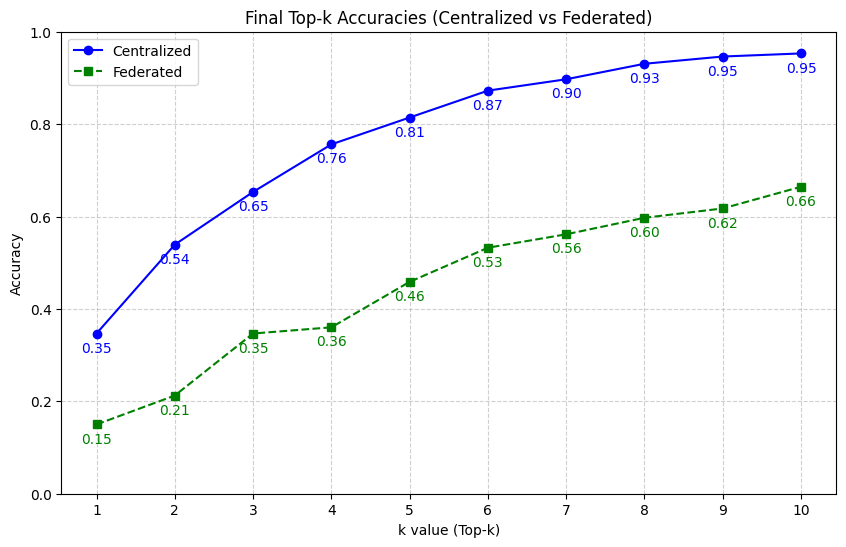

In [26]:
# Plot the performance Centralized vs Federated
# Centralized
x_vals = list(final_metrics.keys())
y_central = [final_metrics[k] for k in x_vals]

# Federated
y_fed = [fed_test_metrics[k] for k in x_vals]

plt.figure(figsize=(10,6))

# Centralized line
plt.plot(x_vals, y_central, marker="o", linestyle="-", color="blue", label="Centralized")

# Federated line
plt.plot(x_vals, y_fed, marker="s", linestyle="--", color="green", label="Federated")

# Styling
plt.xticks(x_vals)
plt.ylim(0,1)
plt.xlabel("k value (Top-k)")
plt.ylabel("Accuracy")
plt.title("Final Top-k Accuracies (Centralized vs Federated)")
plt.legend()

# Annotate centralized points
for x, y in zip(x_vals, y_central):
    plt.text(x, y-0.04, f"{y:.2f}", ha="center", color="blue")

# Annotate federated points
for x, y in zip(x_vals, y_fed):
    plt.text(x, y-0.04, f"{y:.2f}", ha="center", color="green")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
